In [43]:
# tensorflow version
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras version
import keras
print('keras: %s' % keras.__version__)
import pandas as pd
import numpy as np
import pickle, pprint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import warnings
warnings.filterwarnings("ignore")

tensorflow: 2.5.0
keras: 2.5.0


In [47]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

In [3]:
def read_make_image_splits(file):
    """
        given a .pkl file, returns a 3D numpy array
    """

    pkl_file = open(file, 'rb')

    data1 = pickle.load(pkl_file)
    pkl_file.close()

    return data1

## Reading in data


In [26]:
df = pd.DataFrame(read_make_image_splits("image_splits_v2/split_1.pkl"))
df['Index'] = np.arange(len(df))
df.head()

,0,1,2,3,4,5,6,Index
0,diamond,2.25,Ounce,62,DIAMOND SHELLED WALNUTS,prod/00007045004591.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
1,safe + fair,7.5,Ounce,56,SAFE + FAIR BIRTHDAY CAKE POPCORN,prod/00081002359024 (2).jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",1
2,sharper image,1,Each,97,SHARPER IMAGE 1004900 MUSICAL MIC BT,prod/00694202130919.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",2
3,schmidts,2.65,Ounce,82,SCHMIDTS DEO HEMP+PATCHOULI,prod/00810117031923.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",3
4,pioneer,16,Ounce,72,PIONEER WOMAN BBQ STYLED CUTS BEEF BRSK,prod/00003810018341.jpg,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",4


In [5]:
from PIL import Image

## Resizing the image data
The input to resnet is 224X224 so we had to resize the data

In [76]:
df[6] = df[6].apply(lambda x: Image.fromarray(x).resize(size=(224, 224)))

In [77]:
df[6] = df[6].apply(np.array)

In [78]:
df[6] = df[6] / 255
df.head()

,0,1,2,3,4,5,6,Index
0,diamond,2.25,Ounce,62,DIAMOND SHELLED WALNUTS,prod/00007045004591.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",0
1,safe + fair,7.5,Ounce,56,SAFE + FAIR BIRTHDAY CAKE POPCORN,prod/00081002359024 (2).jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",1
2,sharper image,1,Each,97,SHARPER IMAGE 1004900 MUSICAL MIC BT,prod/00694202130919.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",2
3,schmidts,2.65,Ounce,82,SCHMIDTS DEO HEMP+PATCHOULI,prod/00810117031923.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",3
4,pioneer,16,Ounce,72,PIONEER WOMAN BBQ STYLED CUTS BEEF BRSK,prod/00003810018341.jpg,"[[[1.0, 1.0, 1.0], [1.0, 1.0, 1.0], [1.0, 1.0,...",4


In [79]:
df[6][0].shape

(224, 224, 3)

In [9]:
from keras.applications.resnet import ResNet50
from keras.models import Model

In [73]:
model = ResNet50(weights="imagenet")
model

In [28]:
ResNet50().summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [74]:
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [80]:
# extract features from each photo in the directory
def extract_features(input):
    # extract features from each photo
    features = []
    for img in input:
        # reshape data for the model
        img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
        # prepare the image for the VGG model
        # image = preprocess_input(image)
        # get features
        feature = model.predict(img, verbose=0)
        features.append(feature)
    return features

features = extract_features(df[6])

In [81]:
features_df = df[[4, 'Index']]
features_df["Features"] = features
features_df

,4,Index,Features
0,DIAMOND SHELLED WALNUTS,0,"[[0.0, 0.0, 0.0, 0.0, 1.1927669, 0.0, 0.0, 0.9..."
1,SAFE + FAIR BIRTHDAY CAKE POPCORN,1,"[[0.0, 0.0, 0.0, 0.0, 1.4088589, 0.0, 0.0, 0.9..."
2,SHARPER IMAGE 1004900 MUSICAL MIC BT,2,"[[0.0, 0.0, 0.0, 0.0, 1.241569, 0.0, 0.0, 0.96..."
3,SCHMIDTS DEO HEMP+PATCHOULI,3,"[[0.0, 0.0, 0.0, 0.0, 1.1668261, 0.0, 0.0, 0.9..."
4,PIONEER WOMAN BBQ STYLED CUTS BEEF BRSK,4,"[[0.0, 0.0, 0.0049829627, 0.0, 1.3654373, 0.0,..."
...,...,...,...
1873,HERBAL ESS CD BODY ENVY VOLUMIZING,1873,"[[0.0, 0.0, 0.0, 0.0, 1.1290554, 0.0, 0.0, 0.9..."
1874,VLASIC HOT JALAPENO SLICES,1874,"[[0.0, 0.0, 0.0, 0.0, 1.4241706, 0.0, 0.001135..."
1875,GRATIFY GF CHOC PNT BTR PRETZEL TWISTS,1875,"[[0.0, 0.0, 0.0014274705, 0.0, 1.1499461, 0.0,..."
1876,FAGE 08811 CRSOVERS CHRY AMARETTI,1876,"[[0.0, 0.0, 0.0, 0.0, 1.1526244, 0.0, 0.0, 0.8..."


In [82]:
features_df['Description'] = ['startseq ' + word + ' endseq' for word in features_df[4]]

In [83]:
features_df

,4,Index,Features,Description
0,DIAMOND SHELLED WALNUTS,0,"[[0.0, 0.0, 0.0, 0.0, 1.1927669, 0.0, 0.0, 0.9...",startseq DIAMOND SHELLED WALNUTS ...
1,SAFE + FAIR BIRTHDAY CAKE POPCORN,1,"[[0.0, 0.0, 0.0, 0.0, 1.4088589, 0.0, 0.0, 0.9...",startseq SAFE + FAIR BIRTHDAY CAKE POPCORN ...
2,SHARPER IMAGE 1004900 MUSICAL MIC BT,2,"[[0.0, 0.0, 0.0, 0.0, 1.241569, 0.0, 0.0, 0.96...",startseq SHARPER IMAGE 1004900 MUSICAL MIC BT ...
3,SCHMIDTS DEO HEMP+PATCHOULI,3,"[[0.0, 0.0, 0.0, 0.0, 1.1668261, 0.0, 0.0, 0.9...",startseq SCHMIDTS DEO HEMP+PATCHOULI ...
4,PIONEER WOMAN BBQ STYLED CUTS BEEF BRSK,4,"[[0.0, 0.0, 0.0049829627, 0.0, 1.3654373, 0.0,...",startseq PIONEER WOMAN BBQ STYLED CUTS BEEF BR...
...,...,...,...,...
1873,HERBAL ESS CD BODY ENVY VOLUMIZING,1873,"[[0.0, 0.0, 0.0, 0.0, 1.1290554, 0.0, 0.0, 0.9...",startseq HERBAL ESS CD BODY ENVY VOLUMIZING ...
1874,VLASIC HOT JALAPENO SLICES,1874,"[[0.0, 0.0, 0.0, 0.0, 1.4241706, 0.0, 0.001135...",startseq VLASIC HOT JALAPENO SLICES ...
1875,GRATIFY GF CHOC PNT BTR PRETZEL TWISTS,1875,"[[0.0, 0.0, 0.0014274705, 0.0, 1.1499461, 0.0,...",startseq GRATIFY GF CHOC PNT BTR PRETZEL TWIST...
1876,FAGE 08811 CRSOVERS CHRY AMARETTI,1876,"[[0.0, 0.0, 0.0, 0.0, 1.1526244, 0.0, 0.0, 0.8...",startseq FAGE 08811 CRSOVERS CHRY AMARETTI ...


In [84]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(descriptions)
    return tokenizer
tokenizer = create_tokenizer(features_df['Description'])
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
print(tokenizer.word_index)

4265
{'startseq': 1, 'endseq': 2, 'bar': 3, 'b': 4, 'choc': 5, 'dog': 6, 'org': 7, 'blue': 8, 'w': 9, 'original': 10, 'food': 11, 'wash': 12, 'butter': 13, 'chocolate': 14, 'beef': 15, 'mix': 16, 'cd': 17, 'sh': 18, 'chicken': 19, 'oil': 20, 'coconut': 21, 'sauce': 22, 'organic': 23, 'cat': 24, '2': 25, 'chips': 26, 'milk': 27, 'candle': 28, 'honey': 29, 'buffalo': 30, 'lemon': 31, 'prot': 32, 'cereal': 33, 'black': 34, 'salt': 35, 'cream': 36, 'p': 37, 'nut': 38, 'vanilla': 39, 'cheese': 40, 'home': 41, 'bbq': 42, 'peanut': 43, 'ygrt': 44, 'red': 45, 'jar': 46, 'protein': 47, 'water': 48, 'almond': 49, 'sea': 50, 'soup': 51, 'old': 52, 'rice': 53, 'snack': 54, 'kellogg': 55, 'tea': 56, 'green': 57, 'white': 58, 'set': 59, 'storage': 60, 'van': 61, 'gf': 62, 'l': 63, 'mini': 64, 'bacon': 65, 'cake': 66, 'm': 67, 'wild': 68, 'natural': 69, 'apple': 70, 'lime': 71, 'spray': 72, 'h': 73, 'berry': 74, 'dry': 75, 'strawberry': 76, 'juice': 77, 'jerky': 78, 'hot': 79, 'a': 80, 'to': 81, 'swe

In [85]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    for i in range(len(descriptions)):
        # encode the sequence
        seq = tokenizer.texts_to_sequences([descriptions[i]])[0]
        # split one sequence into multiple X,y pairs
        for j in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:j], seq[j]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(photos[i][0])
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [86]:
def max_length(descriptions):
    return max(len(d.split()) for d in descriptions)

In [87]:
max_len = max_length(features_df['Description'])
X1, X2, y = create_sequences(tokenizer, max_len, features_df['Description'], features_df['Features'], vocab_size)
display(X1, X2, y)

array([[0.        , 0.        , 0.        , ..., 2.0303087 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.0303087 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.0303087 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00743491, ..., 1.71931   , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00743491, ..., 1.71931   , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00743491, ..., 1.71931   , 0.        ,
        0.        ]], dtype=float32)

array([[   0,    0,    0, ...,    0,    0,    1],
       [   0,    0,    0, ...,    0,    1,  158],
       [   0,    0,    0, ...,    1,  158, 1573],
       ...,
       [   0,    0,    0, ...,  446, 4264,  132],
       [   0,    0,    0, ..., 4264,  132,  380],
       [   0,    0,    0, ...,  132,  380,  586]], dtype=int32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [88]:
shuffled_df = features_df.sample(frac=1)

In [89]:
train = shuffled_df.iloc[:int(0.8*len(shuffled_df)), :].reset_index(drop=True)
test = shuffled_df.iloc[int(0.8*len(shuffled_df)):, :].reset_index(drop=True)

In [90]:
test

,4,Index,Features,Description
0,KRAFT OLIVE OIL CAESAR DRESSING,870,"[[0.0, 0.0, 0.009196432, 0.0, 1.247306, 0.0, 0...",startseq KRAFT OLIVE OIL CAESAR DRESSING ...
1,LATE JULY BUFFALO QUESO TORTILLA CHIPS,1765,"[[0.0, 0.0, 0.0, 0.0, 1.1686486, 0.0, 0.0, 0.8...",startseq LATE JULY BUFFALO QUESO TORTILLA CHIP...
2,GREEK GODS 57006 HONEY STRWB GREEK YGRT,1663,"[[0.0, 0.0, 0.0, 0.0, 1.0566069, 0.0, 0.0, 0.9...",startseq GREEK GODS 57006 HONEY STRWB GREEK YG...
3,BROO BEER 4N1 WASH HAIR/BODY/FACE/BEARD,355,"[[0.0, 0.0, 0.024540283, 0.0, 1.2024187, 0.0, ...",startseq BROO BEER 4N1 WASH HAIR/BODY/FACE/BEA...
4,DAELMANS SPECULOOS CARAMEL BISCUITS,1524,"[[0.0, 0.0, 0.0046041594, 0.0, 1.2600332, 0.0,...",startseq DAELMANS SPECULOOS CARAMEL BISCUITS ...
...,...,...,...,...
371,ASTV VT-6969 COMPRESSION BERMUDA SHORT,478,"[[0.0, 0.0, 0.0, 0.0, 1.1430876, 0.0, 0.0, 0.8...",startseq ASTV VT-6969 COMPRESSION BERMUDA SHOR...
372,BREAKSTONE 00866 CC DBL HONEY VANILLA,1778,"[[0.0, 0.0, 0.0, 0.0, 1.3894613, 0.0, 0.0, 0.9...",startseq BREAKSTONE 00866 CC DBL HONEY VANILLA...
373,REFLEX MPS-31314 M. THERMAL UNDERWEAR,610,"[[0.0, 0.0, 0.0, 0.0, 1.4516364, 0.0, 0.0, 1.0...",startseq REFLEX MPS-31314 M. THERMAL UNDERWEAR...
374,AVEENO POS AGELESS B/CREAM,1518,"[[0.0, 0.0, 0.0, 0.0, 1.1640369, 0.0, 0.0, 0.9...",startseq AVEENO POS AGELESS B/CREAM ...


In [91]:
X1train, X2train, ytrain =  create_sequences(tokenizer, max_len, train['Description'], train['Features'], vocab_size)
X1test, X2test, ytest=  create_sequences(tokenizer, max_len, test['Description'], test['Features'], vocab_size)


In [92]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [127]:
caption_model = define_model(vocab_size, max_len)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 11)]         0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 11, 256)      1091840     input_12[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 2048)         0           input_11[0][0]                   
____________________________________________________________________________________________

In [128]:
# fit model
caption_model.fit([X1train, X2train], ytrain, epochs=50, verbose=1, validation_data=([X1test, X2test], ytest))


Epoch 1/50
310/310 [==============================] - 17s 43ms/step - loss: 7.4288 - val_loss: 7.0856
Epoch 2/50
310/310 [==============================] - 12s 39ms/step - loss: 6.6317 - val_loss: 7.1825
Epoch 3/50
310/310 [==============================] - 12s 39ms/step - loss: 6.2643 - val_loss: 7.3341
Epoch 4/50
310/310 [==============================] - 12s 39ms/step - loss: 5.9573 - val_loss: 7.5746
Epoch 5/50
310/310 [==============================] - 12s 38ms/step - loss: 5.6940 - val_loss: 7.8902
Epoch 6/50
310/310 [==============================] - 12s 39ms/step - loss: 5.5209 - val_loss: 8.0919
Epoch 7/50
310/310 [==============================] - 12s 38ms/step - loss: 5.2434 - val_loss: 8.3813
Epoch 8/50
310/310 [==============================] - 12s 40ms/step - loss: 4.9285 - val_loss: 8.8718
Epoch 9/50
310/310 [==============================] - 12s 39ms/step - loss: 4.6052 - val_loss: 9.6933
Epoch 10/50
310/310 [==============================] - 12s 39ms/step - loss: 4.220

In [129]:
import random

# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
# generate a description for an image
def generate_desc(cnn_model, model, tokenizer, img, max_length):
    photo = extract_features([img])[0]
    # print(photo)
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        # print(photo, sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text



predicted startseq terra chips blue potato chips endseq
actual TERRA CHIPS BLUE POTATO CHIPS           


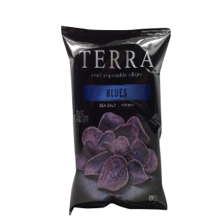

In [182]:
index = random.randint(0, len(features_df))
image, description = df[6][index], df[4][index]
# print(image)
print("predicted", generate_desc(model, caption_model, tokenizer, image, max_len))
print("actual", description)
display(Image.fromarray((image*255).astype(np.uint8)))